<a href="https://colab.research.google.com/github/damithkawshan/Radar-and-Navigation/blob/damithkawshan-patch-1/Radar_Assignment_1_160026P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EN4353 - Radar and Navigation - Assignment 01
###160026P - A. G. D. K. Anhettigama





##Import Libraries and Load .csv files 


In [85]:
#import libraries and csv files

import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv

plt.style.use('default')

url1 = 'https://raw.githubusercontent.com/damithkawshan/Radar-and-Navigation/main/raw_data1.csv'
df1 = pd.read_csv(url1,sep=';',header=None,squeeze=True)

url2 = 'https://raw.githubusercontent.com/damithkawshan/Radar-and-Navigation/main/raw_data2.csv'
df2 = pd.read_csv(url2,sep=';',header=None,squeeze=True)

url3 = 'https://raw.githubusercontent.com/damithkawshan/Radar-and-Navigation/main/raw_data3.csv'
df3 = pd.read_csv(url3,sep=';',header=None,squeeze=True)

df4 = df1.append(df2)


Radar_ADC = {'df1':df1,'df2':df2,'df3':df3,'df4':df4}


##Get the file ID from user


Change filename accordingly to select the csv file.

**df1 : raw_data1.csv**

**df2 : raw_data2.csv**

**df3 : raw_data3.csv**

In [86]:
#get the file to analyse

filename = "df2"
Raw_data = Radar_ADC[filename].to_numpy()


### Define Parameters

* No. of range slots:  $N = 30$ 

* Pulse Repitition Frequency: $f_r = 1800 Hz$

* Initial Sampling Frequency $F_{s(orig)} = 1080kHz$


* Number of samples in raw_data file  $n_{samples} = 18000$


* For noise thresholding:

    >$\sigma_n = 1$

    >$k = 1.3$

* For coherent detection min responses to be a target in certain range slot.

    >$bins_{(min)} = 15$
    

* Speed of Light $C=3\times10^{8}ms^{-1}$

* Speed of rotation of the radar $revol\: speed = 12 \:revols.\: per\: minute$

* Initial azimuth angle $\theta_{init} = 0^0$ 

* Horizontal Beam Width $\theta_H = 2^0$





In [87]:
#parameters

N = 30 # no of bins
fr = 1800 # pulse repitition freq
Fs_orig = 1080*1000 #original sampling freq 1080kHz

#thresholding
sigma_n = 1
k = 1.3

#coherent detection min threshold to being a target
min_bins = 15

C = 3e8
rev_speed = 12
theta_init = 0
theta_h = 2

#Analog to Digital Conversion 
###*(For our problerm downsampling of raw data stream)*


Since one pulse contain 30 bins, required sampling frequency is:
>$F_s = Nf_r$

> $\therefore F_s= 30\cdot1800 = 54kHz$

>$T_s = \frac{1}{F_s} = 18.52\mu s$

  >$T_{sampled} = \frac{n_{samples}}{fs} = \frac{18000}{1080000} = \frac{1}{60} s$

  >$\theta_{revolved} = \frac{revol\ speed \times T_{sampled} \times 360^{\circ}}{60} = 1.2^{\circ}$

  >$echoes\ per\ \theta_H = \frac{\theta_H \times f_r}{6 \times revol\ speed} = 50$

  >$echoes\ for\ 1.2^{\circ} = \frac{echoes\ per\ \theta_H \times 1.2^{\circ}}{\theta_H} = 30$

Therefore dimensions of the data matrix would be $(echoes\ for\ 1.2^{\circ}\times N)= 30\times30$

Since our $1080kHz$ raw data need to be downsampled to $54kHz\:\:$ therefore, downsampling factor $M$ in discrete domain is:

>$M = \frac{1080}{54} = 20$

to simplify the calculations raw data stream is converted into $900\times30$ matrix and where $0^{th}$ row contains required samples with $54kHz$ and it again reshape into $30 \times 30$ matrix which is the intial stage of the datamatrix.

####Perform downsampling

In [88]:
Fs = N*fr #sampling freq
Ts = Fs_orig / Fs #sampling period for the data frame
len_Radar = len(Raw_data) #size of the data frame

no_samples = int(len_Radar/Ts)

sample_matrix=Raw_data.reshape(no_samples,int(Ts)) #reshape into 900x20 matrix (simplify the calculations)

T_sampled = len_Radar/Fs_orig
theta_revol = rev_speed * len_Radar*6/Fs_orig

echo_per_thetaH = (theta_h*fr)/(6*rev_speed)

no_echos = int((echo_per_thetaH * theta_revol)/theta_h)



Radar_sampled = sample_matrix[:,0].reshape(no_echos,N) #get the sampled data from 0th sample ...

In [89]:
echo_per_thetaH

50.0

In [90]:
no_echos

30

#### Let's observe How sampled Raw Data Matrix looks like:

To detect objects threshold detection is used.


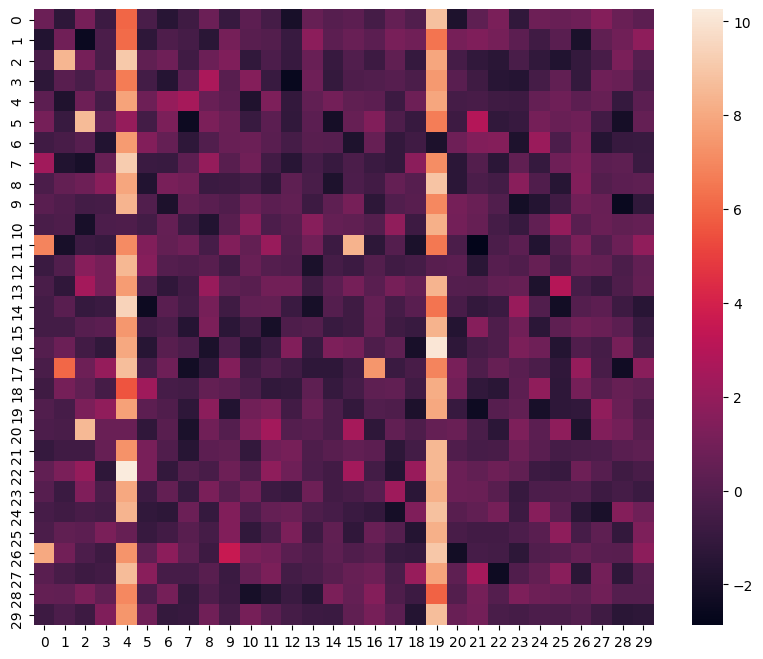

In [91]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(Radar_sampled)

#Noise Threshold Calculation

###Calculate Noise Average

For each sample we have to calculate average noise to perform threshold detection.

To calculate noise average ***21 sample window*** is chosen. Therefore, no. of samples in past video is 6 and present video is 6 and guard band length is 4 samples per one side. (for $0^{th} sample\:$ past video data is not available therefore we have considered only the future video data.)

Noise average $(V_n)_{avg}\:$ for a sample range slot can be obtained as:

>$(V_n)_{avg} = \frac{\sum_{i=5}^{10} (past video) + \sum_{i=5}^{10} (future video)}{12}$

Thresold value for a that sample range slot is:

>$V_{TH}=(V_n)_{avg}+k\cdot \sigma_n $

*(Since all calculations are done in vector form noise average is also obtained as a $30\times30$ matrix)*

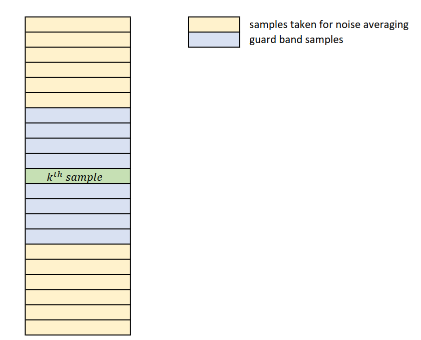

In [92]:
#get the average noise
#get noise window #get prev 10 values next 10 values (ignore 4 nearest values from either sides)

def Noise_average(sample_matrix, k, sigma_n):
  next_samples = sample_matrix[:,5:11]

  A = sample_matrix[:no_samples-1,10:16]
  prev_samples = np.vstack([next_samples[0],A])

  #noise average vector
  Avg_noise = np.mean(np.concatenate((next_samples,prev_samples),axis=1),axis=1)

  #threshold vector
  V_threshold = Avg_noise + k*sigma_n

  return V_threshold

V_threshold = Noise_average(sample_matrix, k, sigma_n).reshape(no_echos,N)

###Let's see how our noise threshold looks like :


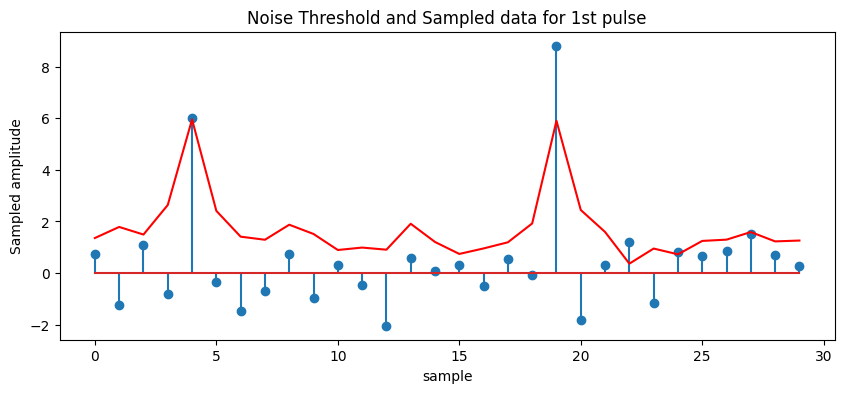

In [93]:
plt.figure(figsize=(10, 4))
ax=plt.stem(Radar_sampled[0,0:30],use_line_collection=True)
ax=plt.plot(V_threshold[0,0:30],color='r')
ax=plt.ylabel('Sampled amplitude')
ax=plt.xlabel('sample')
ax=plt.title('Noise Threshold and Sampled data for 1st pulse')
plt.show()

#Thresold Detector

Very simple and low cost mechanism.

$If\:\: V_{k}>V_{TH} \:\: then \:V_{k} =1 \:otherwise \:0$



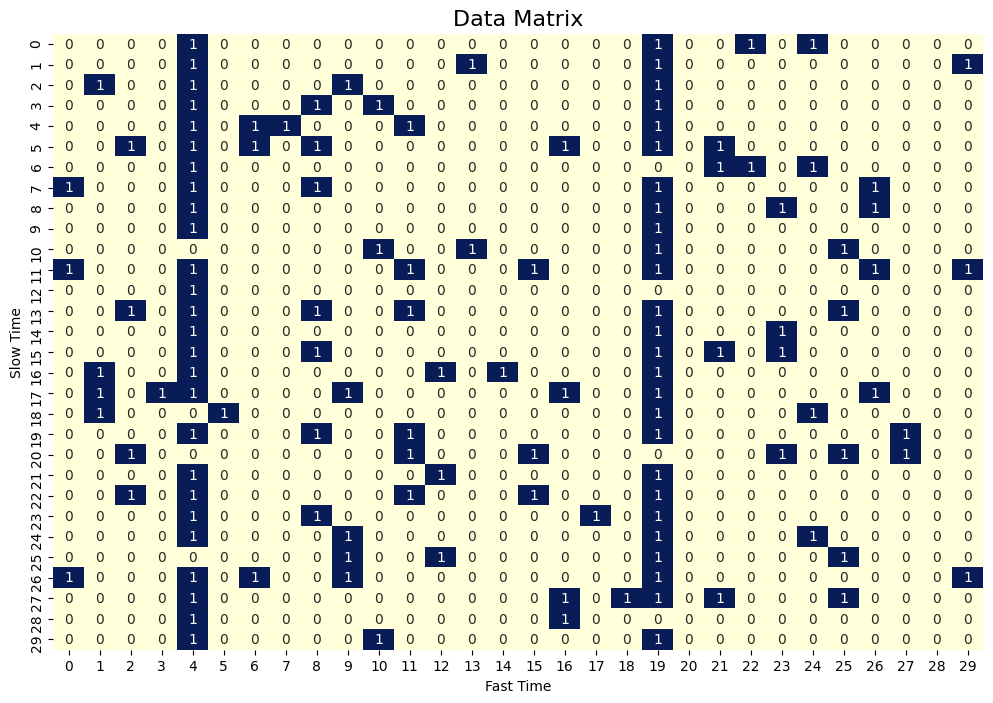

In [94]:
def noise_threshold(data,noise_avg):
  return (data > noise_avg)*1

data_matrix = noise_threshold(Radar_sampled, V_threshold)

f, ax = plt.subplots(figsize=(12,8))
plt.title("Data Matrix",fontsize = 16)
ax = sns.heatmap(data_matrix, square=False,annot=True,cbar=False,cmap="YlGnBu")
ax=ax.set(
      xlabel="Fast Time",
      ylabel="Slow Time")

#Post Detection Integration

***Condition:***

***If count > 0.5[Expected echoes per target per scan]***

***Then there is a target in that range slot***

If target is present in a range slot whole column is replaced by 0.5

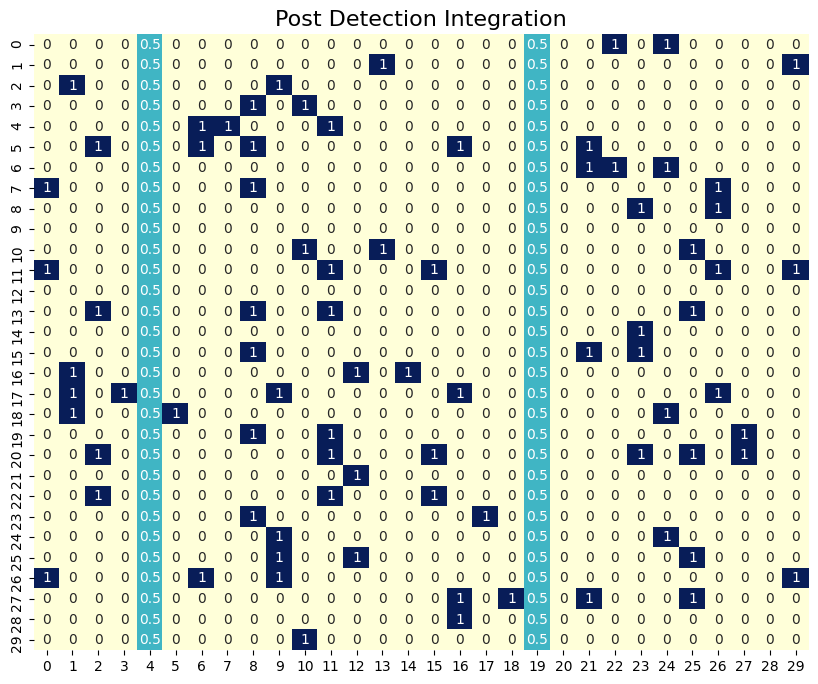

In [95]:
def object_detection(data_mat,threshold):
  dataMatrix=data_mat.astype(np.float)

  range_sum = np.sum(dataMatrix,axis=0)

  object_bins = []

  for i,(itm) in enumerate(range_sum):
    if itm >= threshold:
      object_bins.append(i)
      dataMatrix[:,i] = 0.5 

  return dataMatrix, object_bins

matrix_filtered, objects = object_detection(data_matrix,15)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Post Detection Integration',fontsize = 16)
ax = sns.heatmap(matrix_filtered, square=False,annot=True,cbar=False,cmap="YlGnBu")

In [96]:
objects

[4, 19]

#Cloud Detection

Due to high noise present in the data cloud detection thresholding algorithm is diffrent from object detection.

Following steps were used to remove unwanted noise in sampled data matrix.

####**Stage 1: Thresholding**

1.   $If\:\: V_{k}>V_{TH} \:\: then \:V_{k} =V_{k} \:otherwise \:0$
2.   $If\:\: V_{k}>6 \:\: then \:V_{k} =V_{k} \:otherwise \:0$
3.   normalize values in the matrix and map all non zero values to 1 and zero range slots with objects.

####**Stage 2: Filtering**



1.   Apply noise reduction filter with $7\times7$ kernel with $3$ as threshold value 
2.   Apply noise reduction filter with $5\times5$ kernel with $2$ as threshold value 

####**Stage 3: Complete Missing Values**



1.   Fill gaps with $2$ empty cells
2.   Apply noise reduction filter with $5\times5$ kernel with $4$ as threshold value 
3.   Fill gaps with $1$ empty cells
4. Apply noise reduction filter with $3\times3$ kernel with $2$ as threshold value 

#### **Stage 4: Fill Cloud Contour**


1.   Use floodfill algorithm to fill cloud cointour within cloud boundary
2.   Apply noise reduction filters to edge rows and columns with $3\times3$ kernel with $2$ as threshold.

#### **Stage 5: Visualization**



1.   Map clouds to $1$ and objects to $0.5$ and display final Data Matrix.
2.   Perform Calculations and display azimuth information.


###Stage 1: Thresholding

>$If\:\: V_{k}>V_{TH} \:\: then \:V_{k} =V_{k} \:otherwise \:0$

>$V_{k}>6 \:\: then \:V_{k} =V_{k} \:otherwise \:0$

>$V_k = \frac{V_k}{max(Data\: Matrix)}$

>$if\: V_k > 0 \:then\: V_k = 1 \: otherwise\: 0 $

>Set range slots with objects to zero



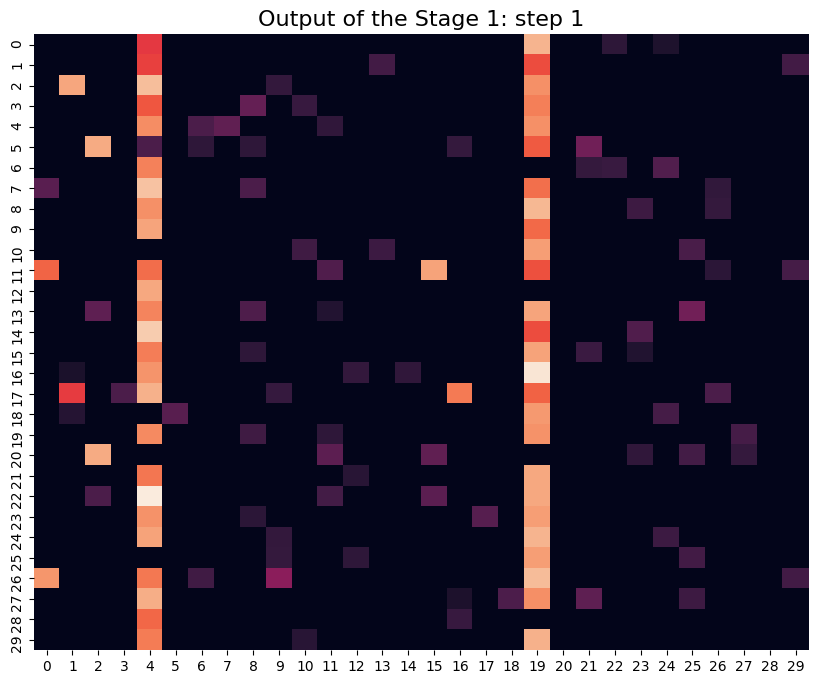

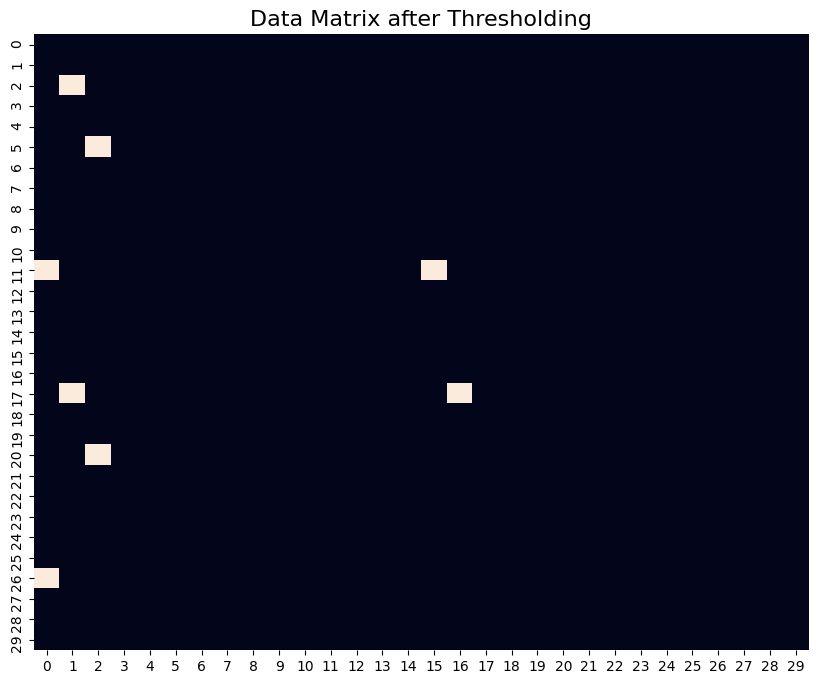

In [97]:

#apply thresholding step1
Radar_filtered = (np.where(Radar_sampled>V_threshold,Radar_sampled,0)/1).reshape(no_echos,N)

#appply thresholding step2
Radar_filtered1 = np.where(Radar_filtered>6,Radar_filtered,0)

#appply thresholding step3
Radar_filtered2 = Radar_filtered1/np.max(Radar_filtered1)

#convert image to binary and remove objects
Radar_binary = np.where(Radar_filtered2>0,1,0)
Radar_binary[:,objects] = 0

f, ax = plt.subplots(figsize=(10,8))
plt.title('Output of the Stage 1: step 1',fontsize = 16)
ax = sns.heatmap(Radar_filtered.reshape(no_echos,N),cbar=False)

#remove object responses
f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Thresholding',fontsize = 16)
ax = sns.heatmap(Radar_binary.reshape(no_echos,N),cbar=False)

###Stage 2: Filtering 

####***noise_reduction() function***

  args: 
  1.   martrix : Data Matrix to be filtered
  2.   kernel_offset : size of the kernel $[kernel \:size = (2*kernel\_offset + 1)\times(2*kernel\_offset + 1) ]$
  3. threshold : threshold value of the kernel 

return : Filtered Data matrix

>$for\: matrix[i,j],$

>$kernel = matrix[i-kernel\_offset:i+kernel\_offset,j-kernel\_offset:j+kernel\_offset]$

>$if \sum(values\: in \:kernel)< threshold \: \:then$

>$matrix[i-(kernel\_offset-1):i+kernel\_offset,j-(kernel\_offset-1):j+kernel\_offset] = 0$

####.
####***noise_1D() function***

  args: 
  1.   martrix : Data Matrix to be filtered
  2.   kernel_offset : size of the kernel $[kernel \:size = 2*kernel\_offset + 1]$
  3. threshold : threshold value of the kernel 

return : Filtered Data matrix

>**For this function we are considering first and last rows/columns of the matrix to filter edge cases**

>$arr$ = first/last of rows/columns of the data matrix.

>$for \: arr[i],$

>$kernel = arr[i-kernel\_offset,i+kernel\_offset]$

>$if \sum(values\: in \:kernel)< threshold \: \:then$

>$arr[i] = 0$


###Apply noise_reduction() filter to data matrix 

1.   Apply noise reduction filter with $7\times7$ kernel with $3$ as threshold value 
2.   Apply noise reduction filter with $5\times5$ kernel with $2$ as threshold value 

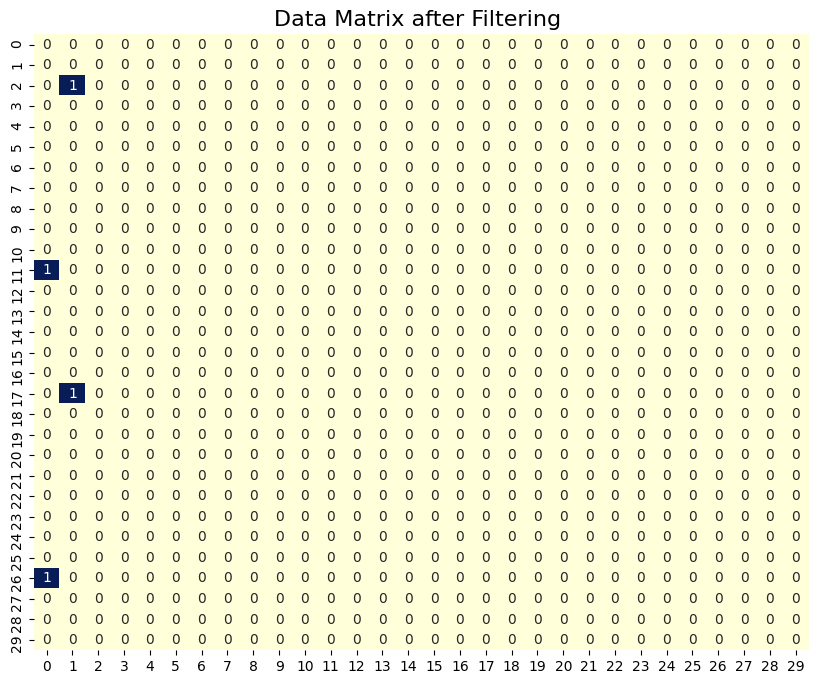

In [98]:
#noise reduction function
def noise_reduction(matrix,kernel_offset,threshold):
  h,w = matrix.shape

  for i in range (0+kernel_offset,h-kernel_offset):
    for j in range (0+kernel_offset,w-kernel_offset):
      kernel = matrix[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1]
      if matrix[i,j]: 
        sum = np.sum(kernel)
        if sum < threshold:
          matrix[i:min(i-2,i),j:min(i-2,i)] = 0
          matrix[i-(kernel_offset-1):i+(kernel_offset),j-(kernel_offset-1):j+(kernel_offset)] = 0
  return matrix

def noise_1D (matrix,kernel_offset,threshold):
  h,w = matrix.shape

  rows_0 = matrix[0,:]
  rows_1 = matrix[h-1,:]

  col_0 = matrix[:,0]
  col_1 = matrix[:,w-1]

  for i in range (0,w-kernel_offset):
    kernel = rows_0 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      rows_0[i]=0

  for i in range (0,w-kernel_offset):
    kernel = rows_1 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      rows_1[i]=0

  for i in range (0,h-kernel_offset):
    kernel = col_0 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      col_0[i]=0
  for i in range (0,h-kernel_offset):
    kernel = col_1 [i-kernel_offset:i+kernel_offset+1]
    if np.sum(kernel)<3:
      col_1[i]=0
  return matrix

#apply noise filters
interm_noisy = noise_reduction(Radar_binary.reshape(no_echos,N),3,3)
binary_filtered = noise_reduction(interm_noisy.reshape(no_echos,N),2,2)

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Filtering ',fontsize = 16)
ax = sns.heatmap(binary_filtered, square=False,annot=True,cbar=False,cmap="YlGnBu")

### Stage 3: Complete Missing Values


####***draw_lines() function***

args:

1.   AAA - data matrix 

return : Data matrix with completed gaps span to $2$ cells

  >$kernel = AAA[i:i+kernel\_offset,j:j+kernel\_offset]$

1. pass kernel to fill_two() function

2. flip the resulting kernel horizontally and pass again to fill_two() function

3. transpose the resulting kernel and pass again to fill_two() function

*above transformations are done to cover all cases easily ($\because$ symmetry of the cases)*
 
####***fill_two() function***

args:
1. kernel : kernel to be analyses

return : kernel with completed gaps span to $2$ cells

following cases are considered $(0  \leq i < 4)$:

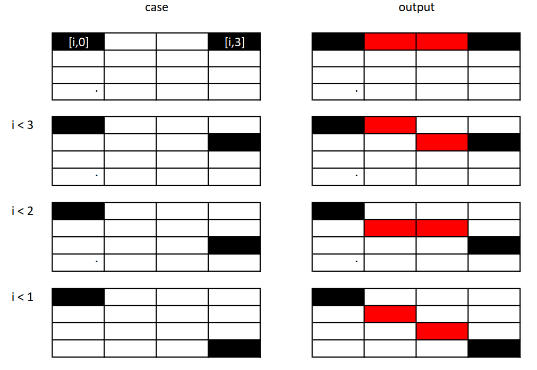

####***draw_lines1() function***

Similar to draw_lines2 this functions fill the gaps span to $1$ cell by calling fill_one function

####***fill_one() function***

args:
1. kernel : kernel to be analyses

return : kernel with completed gaps span to $1$ cells

following cases are considered $(0  \leq i < 3)$:

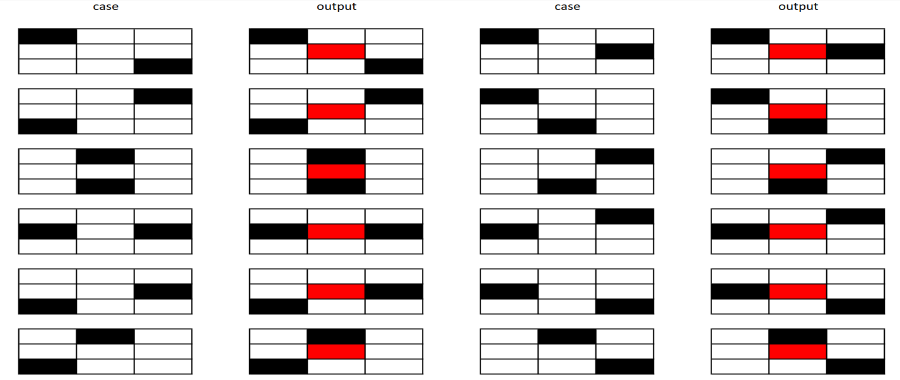

####Fill missing values with noise filters.

1.   Fill gaps with $2$ empty cells
2.   Apply noise reduction filter with $5\times5$ kernel with $4$ as threshold value 
3.   Fill gaps with $1$ empty cells
4. Apply noise reduction filter with $3\times3$ kernel with $2$ as threshold value 


In [99]:
#fill max distance == 2 

def fill_two(kernel):
  def filter(kernel):

    for i in range (4):
        if  (kernel[i,0] ==1 and kernel[i,3]==1) : 
          # print('0***')
          kernel[i,1:3] = 4 
        elif (i<3) and (kernel[i,0] ==1 and kernel[i+1,3]==1) :
          # print('*0**')
          kernel[i,1] = 5
          kernel[i+1,2]=5
        elif (i<2) and (kernel[i,0] ==1 and kernel[i+2,3]==1) :
          # print('**0*')
          kernel[i+1,1] = 6
          kernel[i+2,2]=6
        elif (i<1) and (kernel[i,0] ==1 and kernel[i+3,3]==1) :
          # print('***0')
          kernel[i+1,1] = 7
          kernel[i+2,2]=7

    return kernel 


  return filter(kernel)

# fill max distance =1

def fill_ones(kernel):

    if (kernel[0,0] == 1 and kernel[2,2] == 1) or (kernel[0,2] == 1 and kernel[2,0] == 1)  or (kernel[1,0] == 1 and kernel[1,2] == 1) or (kernel[0,1] == 1 and kernel[2,1] == 1): 
      kernel[1,1] = 2

    elif (kernel[0,0] == 1 and (kernel[2,1] == 1 or kernel[1,2] == 1)) and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[0,2] == 1 and (kernel[1,0] == 1 or kernel[2,1] == 1))and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[2,0] == 1 and (kernel[0,1] == 1 or kernel[1,2] == 1))and (3 not in kernel): kernel[1,1] = 3
    elif (kernel[2,2] == 1 and (kernel[1,0] == 1 or kernel[0,1] == 1))and (3 not in kernel): kernel[1,1] = 3   

    return kernel


def draw_lines2 (AAA):
  h,w = AAA.shape
  kernel_offset = 3
  for i in range (0,h-kernel_offset):
    for j in range (0,w- kernel_offset):
      kernel = AAA[i:i+kernel_offset+1,j:j+kernel_offset+1]

      CCC = fill_two(kernel)
      DDD =  np.flip(fill_two(np.flip(CCC,axis=1)),axis=1)
      AAA[i:i+kernel_offset+1,j:j+kernel_offset+1] = np.transpose(fill_two(np.transpose(DDD)))
  return AAA

def draw_lines1 (AAA):
  h,w = AAA.shape
  kernel_offset = 4
  for i in range (0+kernel_offset,h-kernel_offset):
    for j in range (0+kernel_offset,w-kernel_offset):
      kernel = AAA[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1]
      if np.sum(kernel)<5:
        BBB = fill_ones(kernel)
        AAA[i-kernel_offset:i+kernel_offset+1,j-kernel_offset:j+kernel_offset+1] = BBB

  return AAA

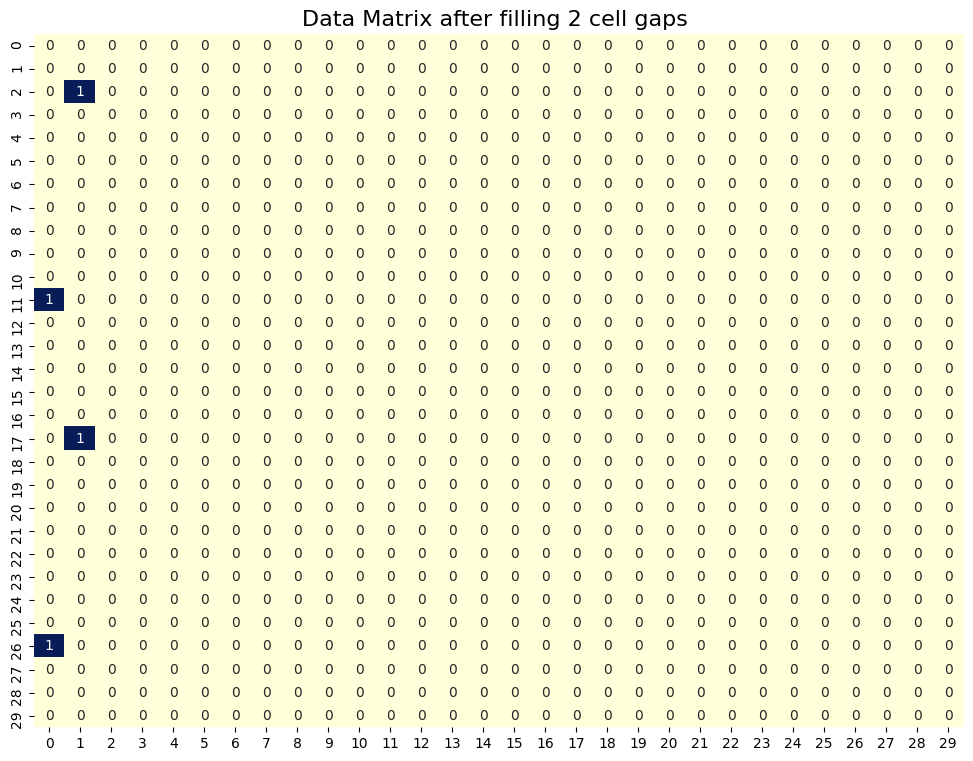

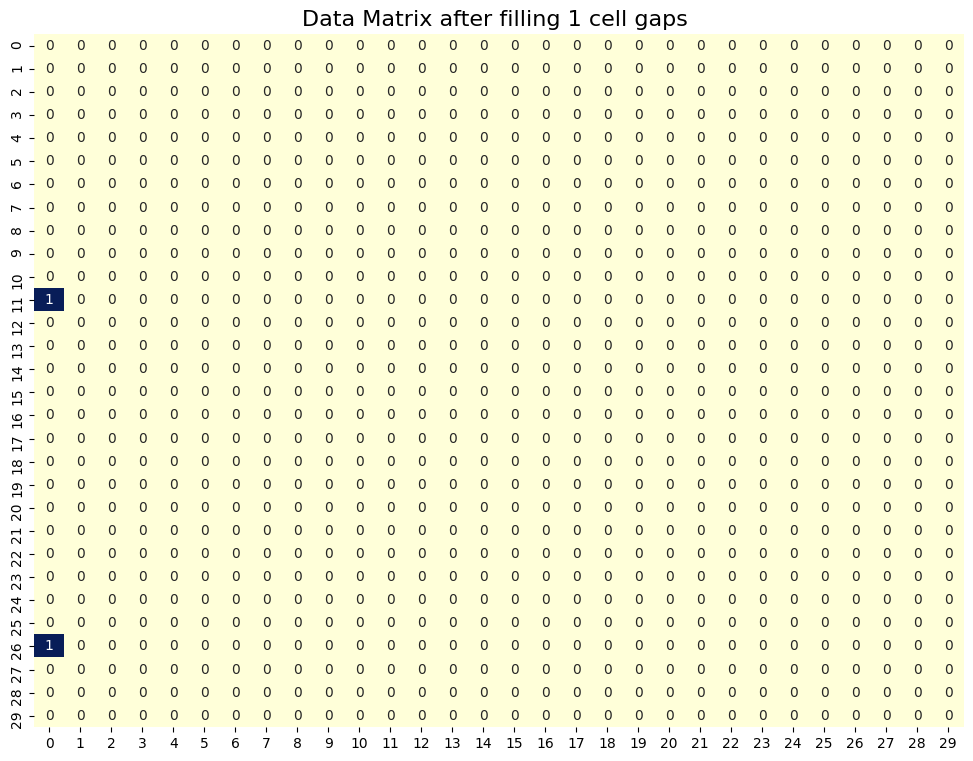

In [100]:
#fill 2 blanks
draw_2 =(draw_lines2 (binary_filtered)>0)*1

f, ax = plt.subplots(figsize=(12,9))
plt.title('Data Matrix after filling 2 cell gaps ',fontsize = 16)
ax = sns.heatmap(draw_2, square=False,annot=True,cbar=False,cmap="YlGnBu")

#noise filter
draw2_filt= noise_reduction(draw_2,2,4)

#fill 1 blank
draw_1 =(draw_lines1 (draw2_filt)>0)*1

draw1_filt= noise_reduction(draw_1,1,3)

f, ax = plt.subplots(figsize=(12,9))
plt.title('Data Matrix after filling 1 cell gaps ',fontsize = 16)
ax = sns.heatmap(draw_1, square=False,annot=True,cbar=False,cmap="YlGnBu")

### Stage 4: Fill Cloud Contour


1.   Use floodfill algorithm to fill cloud cointour within cloud boundary
2.   Apply noise reduction filters (***noise_1D() function*** - mentioned in filtering seciton) to edge rows and columns with $3\times3$ kernel with $2$ as threshold.


In [101]:
data_matrix_uint=draw_1.astype(np.uint8)
floodFill=cv.floodFill(data_matrix_uint, None, seedPoint=(0,0), newVal=5)

matrix_ret=floodFill[1].reshape(no_echos,N)
dataMtrix_processed = np.where(matrix_ret==5,0,1)


there can be noisy bins in the edges of the matrix. we can remove them now by traversing 1D kernel along columns/rows.

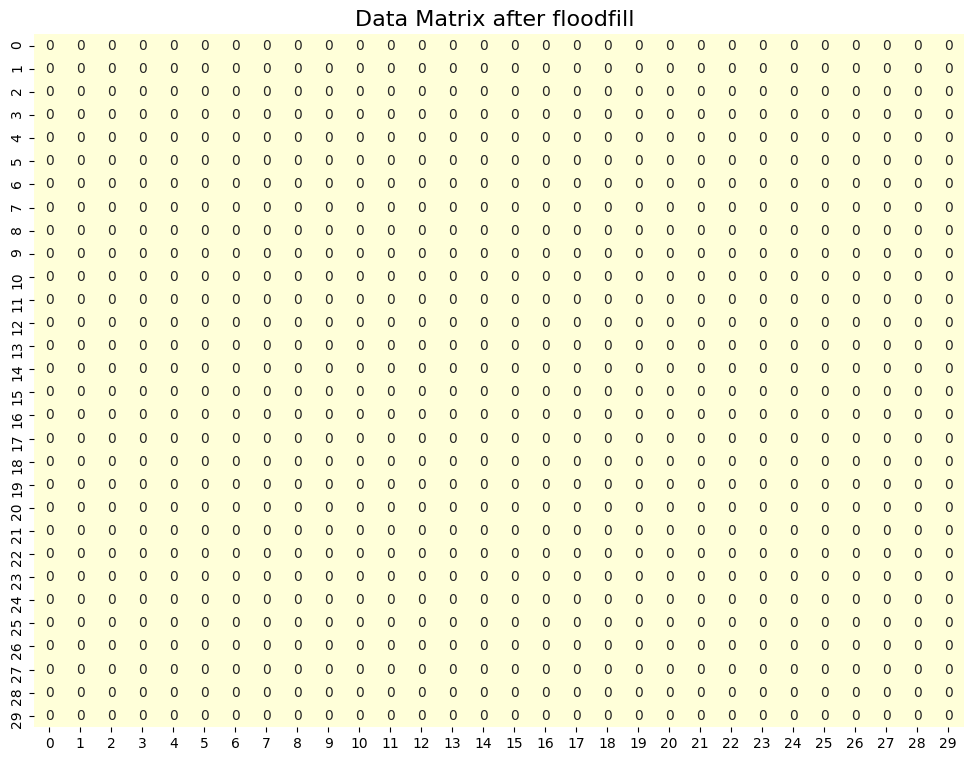

In [102]:
dataMatrix_final=noise_1D (dataMtrix_processed,3,2).astype(np.float)

f, ax = plt.subplots(figsize=(12,9))
plt.title('Data Matrix after floodfill ',fontsize = 16)
ax = sns.heatmap(dataMatrix_final, square=False,annot=True,cbar=False,cmap="YlGnBu")

### Stage 5: Visualization

1.   Map clouds to $1$ and objects to $0.5$ and display final Data Matrix.
2.   Perform Calculations and display azimuth information.



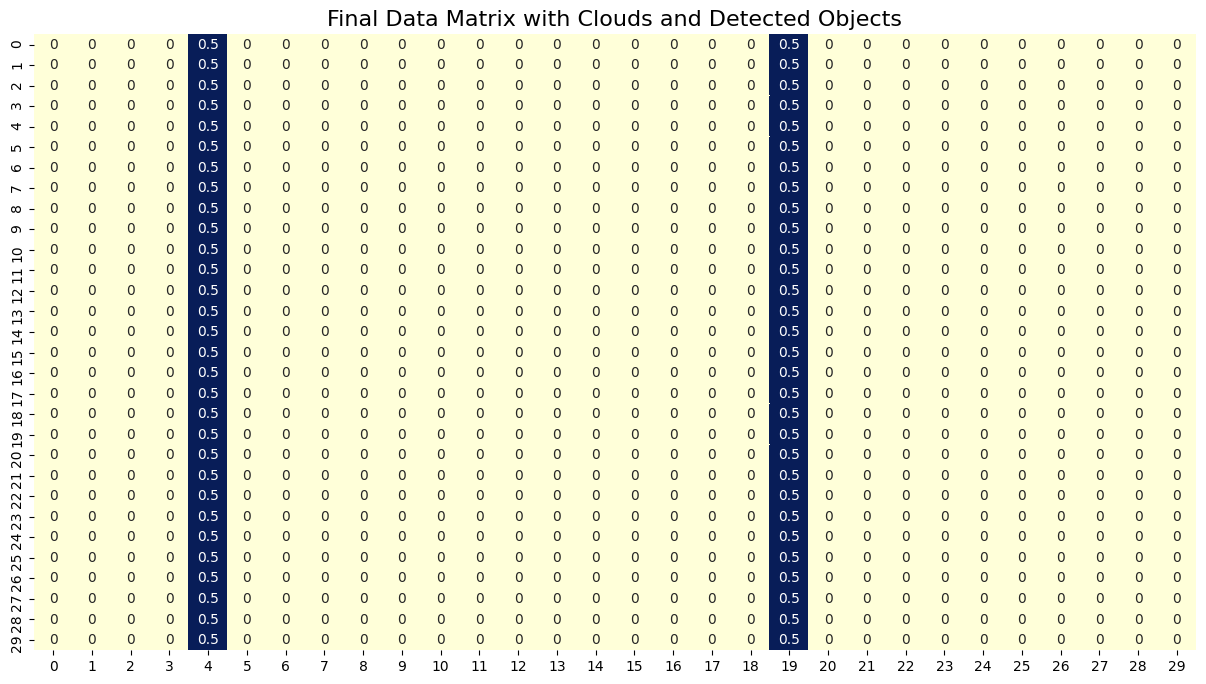

In [103]:
#add object columns
dataMatrix_final[:,objects]=0.5

f, ax = plt.subplots(figsize=(15,8))
plt.title('Final Data Matrix with Clouds and Detected Objects',fontsize = 16)
ax = sns.heatmap(dataMatrix_final, square=False,annot=True,cbar=False,cmap="YlGnBu")

#####Display range of the objects:

For range and azimuth angle calculations:
  
  >$\Delta R = \frac{c \times T_{s}}{2} = 2778m$ 

  > $\omega_{radar} = \frac{revol\:speed\times2\pi}{60}$

To calculate the range and azimuth angle of the target following equations are used.

$
\\
\theta_k = \theta_{init} + \omega_{radar}\times \frac{1}{2\cdot F_s} \times bin\_number
\\
\\
R_k = \Delta R \times bin\_number 
\\
\\
p_k = (R_k, \theta_k)$


In [104]:


if len(objects) != 0:
  k = (rev_speed*360/60) * (1/(2*Fs))

  azymuth = theta_init+ np.dot(np.add(objects,1),k)
  range_m = np.dot(C/(2*Fs),np.add(objects,1))

  for i,(r, theta) in enumerate(zip(range_m, azymuth)):
    print(f'Target {i} is at ({r*1e-3:.3f}km, {theta:.3f}deg)')
else:
  print('No target detected')
  azymuth = []
  range_m = []

Target 0 is at (13.889km, 0.003deg)
Target 1 is at (55.556km, 0.013deg)


In [105]:
#plot target vectors in radar screen



def plot_point(angle, length_m):
  norm_fact  = N * (C/2) * (1/(fr * N) )
  
  if len(length_m) !=0:
    length = length_m/1000
  else:
    length = length_m
  fig = plt.figure(figsize=(8,8))
  plt.style.use('dark_background')
  x, y = (0,0)                                                                    
  font_dict = {'size':'12', 'color':'xkcd:chartreuse'}
  n_target = 1
  plt.polar()   
  fig.set_facecolor('xkcd:black')                                                                
  if len(angle) == 0:                                                             
    plt.text(0, 0,'x' , font_dict)

  for az_angle, range_val in zip(angle, length):
    plt.polar(az_angle, range_val, 'ro', markersize=10)                           
    str_ = f'T:0{n_target}\n({range_val:.2f}km, {az_angle:.2f} deg)'
    plt.text(az_angle - 0.05, range_val+0.05, str_, font_dict)                    
    n_target += 1

  plt.title('Radar Screen', {'size':'16', 'color':'xkcd:chartreuse', 'weight':'normal',
          'verticalalignment':'bottom'})
  fig.show()

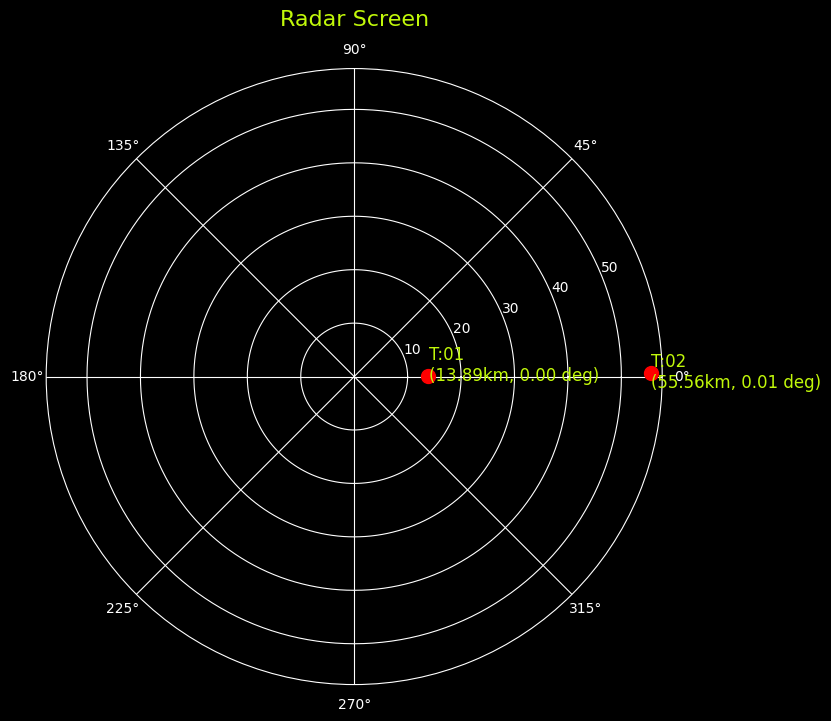

In [106]:
ax=plot_point( azymuth,range_m)